Analysis of the 2016 presidential elections tweets

In [62]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [104]:
data = pd.read_csv("data.csv")
#subset = data.sample(n = 100000)
#subset = subset.drop(['id','user_location','user_id','created_at','retweet_count','user_following','user_followers','user_statuses','favorite_count','user_friends'],axis=1)
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 203274 to 124232
Data columns (total 3 columns):
user_screen        99962 non-null object
original_author    99962 non-null object
tweet_text         99962 non-null object
dtypes: object(3)
memory usage: 3.1+ MB


The graph will be a directed multi graph where the source is the author of the tweet, and the target is the original author of the tweet.

We will need to remove the rows where we don't have an original author, i.e. the tweets that aren't retweets or quotes


In [105]:
tmp = subset.loc[subset['tweet_text'] != "Null"]
tmp = tmp.loc[tmp['original_author'] != "Null"]

In [107]:
tmp.head(100)

,user_screen,original_author,tweet_text
140786,Anevilweasel,FrankTheDoorman,"RT @FrankTheDoorman: ""Hillary Clinton doesn't ..."
12302,mrpshropshire,ggreenwald,RT @ggreenwald: Another poll showing Trump in ...
6359,Andrianamik,realDonaldTrump,RT @realDonaldTrump: My thoughts and prayers a...
143460,anyabelisle,samstein,RT @samsteinhp: Damn. this ad from Clinton \r\...
61467,studumpling,ch000ch,RT @ch000ch: TRUMP: i grab women by the pussy\...
...,...,...,...
145033,clannadlore,SheriffClarke,RT @SheriffClarke: The best thing about Clinto...
131669,taylor__brooke_,daannnnnnyyyyy,RT @DanielEggerding: This is why we cannot let...
63273,SeatMA1,KattLivesMatter,RT @KatQ1: OUTED-HIll Can Run From Her Lies Bu...
24955,KeithPullin,realDonaldTrump,RT @realDonaldTrump: My thoughts and prayers a...


In [108]:
import networkx as nx
retweets_G = nx.from_pandas_edgelist(tmp, source='user_screen',
                                     target='original_author',
                                     edge_attr=True,
                                     create_using=nx.MultiDiGraph())

In [109]:
nx.write_edgelist(retweets_G, 'retweets_graph.csv')

In [110]:
print("The graph has", len(retweets_G.nodes), "nodes and", len(retweets_G.edges), "edges")

The graph has 40673 nodes and 50880 edges


In [111]:
print(nx.info(retweets_G))

Name: 
Type: MultiDiGraph
Number of nodes: 40673
Number of edges: 50880
Average in degree:   1.2510
Average out degree:   1.2510


In [112]:
nx.density(retweets_G)

3.0757098752900236e-05

In [113]:
nx.number_of_selfloops(retweets_G)

373

In [114]:
nx.degree_assortativity_coefficient(retweets_G)

-0.008811534707932474

Network degrees

In [115]:
import numpy as np
import seaborn as sns

In [116]:
sns.set()

In [117]:
def get_frequencies(degree_dict):
    degree_freq = {}

    for node, deg in degree_dict.items():
        if deg in degree_freq:
            degree_freq[deg] += 1
        else:
            degree_freq[deg] = 1

    x = sorted(degree_freq.keys())
    y = [degree_freq[k] for k in x]
    return x, y

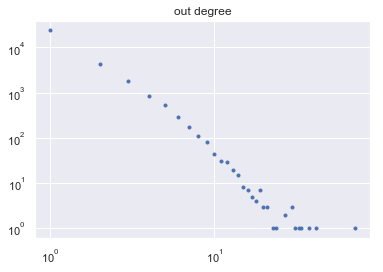

In [118]:
x, y = get_frequencies(dict(retweets_G.out_degree(set(data.user_screen))))
# log-log scale
plt.title("out degree")
plt.loglog(x, y, linestyle='None', marker='.', )
plt.show()

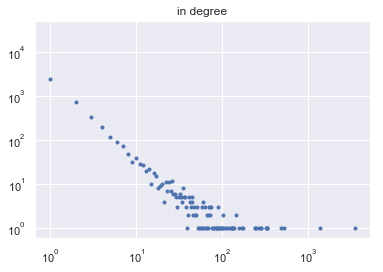

In [119]:
x, y = get_frequencies(dict(retweets_G.in_degree(set(data.user_screen))))
# log-log scale
plt.title("in degree")
plt.loglog(x, y, linestyle='None', marker='.', )
plt.show()


Friendship paradox

The friendship paradox is the phenomenon first observed by the sociologist Scott L. Feld in 1991 that most people have fewer friends than their friends have, on average.


In [120]:
node_degrees = {}
for node, avg in nx.average_neighbor_degree(retweets_G, source='in').items():
    node_degrees[node] = (retweets_G.in_degree[node], avg)
    
# node_degrees = [(o, a) for (o, a) in node_degrees.values()]

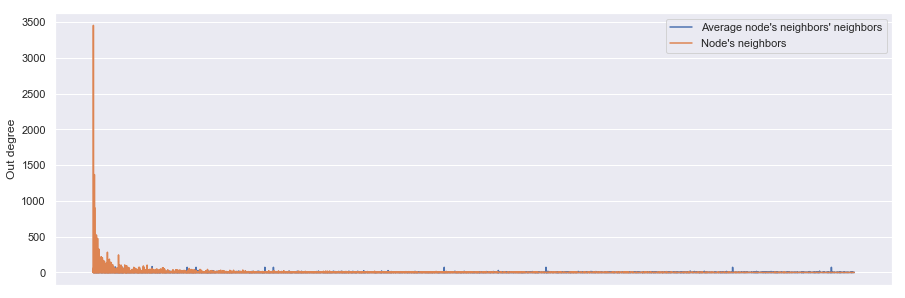

Тhе Paradox is true for 75.64% of the total population. That is 30764 of 40673 total nodes. 
On average their neighbors have 0.39 more retweets.


In [121]:
# node_degrees.sort(key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(15,5))
# plot average neighbors degrees
plt.plot([a for (_, a) in node_degrees.values()], label="Average node's neighbors' neighbors")
# plot nodes' degrees
plt.plot([o for (o, _) in node_degrees.values()], label="Node's neighbors")
plt.legend(loc='upper right')
plt.ylabel('Out degree')

# remove x-axis tics
plt.xticks([])

paradox_num = 0 # number of nodes that have the friendship paradox
avg_deviation = 0 # average more friends
for out, avg in node_degrees.values():
    if avg >= out:
        paradox_num += 1
        avg_deviation += avg - out
        
avg_deviation /= len(node_degrees.values())
percent = paradox_num / len(node_degrees.values()) * 100
plt.show()
print("Тhе Paradox is true for {:.2f}% of the total population. That is {} of {} total nodes."
      .format(percent, paradox_num, len(node_degrees.values())),
     "\nOn average their neighbors have {:.2f} more retweets.".format(avg_deviation))

# Calculating PageRank for the network

These are from the smaller subset graph

In [122]:
page_rank = nx.pagerank_scipy(retweets_G)

And displaying the top 30

In [123]:
sorted(page_rank.items(), key=lambda kv: kv[1], reverse=True)[:30]

[('realDonaldTrump', 0.02801488328703519),
 ('HillaryClinton', 0.011386866839280634),
 ('wikileaks', 0.008264961598818071),
 ('thehill', 0.004388230001876851),
 ('KellyannePolls', 0.0041738945851675325),
 ('Zeddary', 0.0037972398982888266),
 ('mitchellvii', 0.003364776888102119),
 ('CNNPolitics', 0.003052063143423849),
 ('double_cupp_me', 0.002949822116835278),
 ('FoxNews', 0.002612626074749075),
 ('LittleMissFlint', 0.0025739816163930992),
 ('CNN', 0.0023904201837495445),
 ('brazenqueer', 0.002368556906012251),
 ('nytimes', 0.0022879793853025038),
 ('TeamTrump', 0.002285809940610507),
 ('PrisonPlanet', 0.0022756358040606126),
 ('mike_pence', 0.0022298835322923814),
 ('TrumpSuperPAC', 0.0021986993911184563),
 ('LindaSuhler', 0.0021842279213765046),
 ('SethMacFarlane', 0.0021137892328253133),
 ('jonfavs', 0.0020915983056219345),
 ('samstein', 0.0019326731235743224),
 ('tonyschwartz', 0.001575840110715458),
 ('chrislhayes', 0.0015220513112504763),
 ('SopanDeb', 0.0014954266435799784),
 (

Community detection

In [127]:
import community
G2 = retweets_G.to_undirected()
nx.write_edgelist(G2, 'retweetsG2.csv')
g2 = pd.read_csv('retweetsG2.csv')

ParserError: Error tokenizing data. C error: Expected 6 fields in line 4582, saw 8


In [39]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

AttributeError: module 'networkx.algorithms.community' has no attribute 'best_partition'


Community detection using the Girvan-Newman method

The idea is there will be 2 large communities

In [ ]:
from random import random
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    max_cent = max(centrality.values())
    # Scale the centrality values so they are between 0 and 1,
    # and add some random noise.
    centrality = {e: c / max_cent for e, c in centrality.items()}
    # Add some random noise.
    cemntrality = {e: c + random() for e, c in centrality.items()}
    return max(centrality, key=centrality.get)

import copy

loops = copy.deepcopy(list(nx.selfloop_edges(retweets_G)))
retweets_G.remove_edges_from(loops)

comp = nx.algorithms.community.centrality.girvan_newman(retweets_G, most_valuable_edge=most_central_edge)

d = tuple(sorted(c) for c in next(comp))
for community in d:
    print(len(community))

In [ ]:
gn_dict_communities = {}

for i, c in enumerate(d):
    print ("Community {}".format(i))
    for node in c:
        gn_dict_communities[node] = i + 1
        
for node in retweets_G:
    if node not in gn_dict_communities.keys():
        gn_dict_communities[node] = -1